### Week 7 Homework: Titanic using Random Forest Classifiers
<li> Author: Melanie Klein
<li> Class: CSC 570R

In [412]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
import pandas as pd

%matplotlib inline

In [413]:
#Import the data
X = pd.read_csv("Titanic/train.csv")

#Store the result set in its own variable
y = X.pop("Survived")

In [414]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [415]:
#Impute missing Age values using median
X["Age"].fillna(X.Age.mean(), inplace=True)

#Transform Age variable into categorical: child and adult
#Distinction between adult and child based on Encyclopedia Titanica: https://www.encyclopedia-titanica.org/children-on-titanic/

age_bins = [0.0, 14.0, 80.0]
age_names = ['child', 'adult']
X['AgeCategory'] = pd.cut(X.Age, age_bins, labels=age_names)
X['AgeCategory'] = X['AgeCategory'].astype(dtype='str')
X['AgeCategory'].value_counts(dropna=False)

adult    814
child     77
Name: AgeCategory, dtype: int64

In [416]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCategory
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult


In [417]:
X.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked,AgeCategory
count,891,891,891,204,889,891
unique,891,2,681,147,3,2
top,"Harmer, Mr. Abraham (David Lishin)",male,347082,G6,S,adult
freq,1,577,7,4,644,814


In [418]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [419]:
# Drop variables I don't intend to use (including the old numeric Age variable)
X.drop(["Name", "Ticket", "PassengerId", "Age"], axis=1, inplace=True)

In [420]:
# Change the new cabin variables to replace non-"None" values with just the cabin's first letter
def clean_cabin(x):
    try:
        if x == "None":
            return "None"
        else:
            return x[0]
    except TypeError:
        return "None"
X["Cabin"] = X.Cabin.apply(clean_cabin)

#Review data again
X.head()

,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,AgeCategory
0,3,male,1,0,7.2500,None,S,adult
1,1,female,1,0,71.2833,C,C,adult
2,3,female,0,0,7.9250,None,S,adult
3,1,female,1,0,53.1000,C,S,adult
4,3,male,0,0,8.0500,None,S,adult


In [421]:
#Dummy coding for categorical variables
categorical_variables = ['Sex', 'Embarked', 'AgeCategory', 'Cabin']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [422]:
pd.set_option('display.max_columns', None)
X.head()

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S,AgeCategory_adult,AgeCategory_child,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T
0,3,1,0,7.2500,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0,7.9250,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,0,53.1000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,0,0,8.0500,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [423]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [424]:
#Try another model
model = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
print ("C-stat: ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

C-stat:  0.876898326898


### Tuning hyperparameters

### n_estimators

30 trees
C-stat:  0.872200772201

50 trees
C-stat:  0.874839124839

100 trees
C-stat:  0.876898326898

200 trees
C-stat:  0.880115830116

500 trees
C-stat:  0.877027027027

1000 trees
C-stat:  0.878314028314

2000 trees
C-stat:  0.876898326898



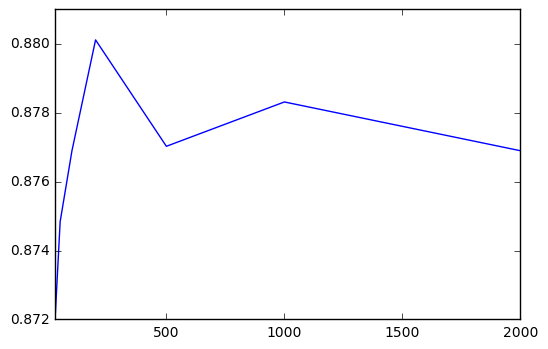

In [425]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestClassifier(n_estimators=trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    print (trees, "trees")
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, n_estimator_options).plot();

### max_features

auto option
C-stat:  0.880115830116

None option
C-stat:  0.886550836551

sqrt option
C-stat:  0.880115830116

log2 option
C-stat:  0.880115830116

0.9 option
C-stat:  0.887902187902

0.2 option
C-stat:  0.880115830116



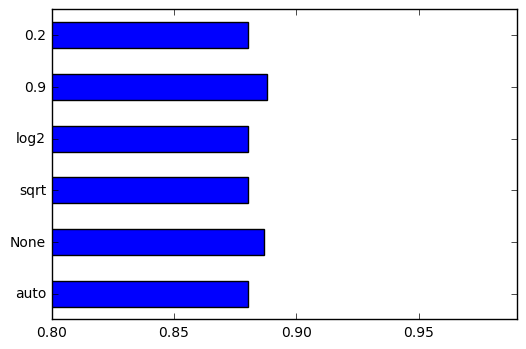

In [426]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X_train, y_train)
    print (max_features, "option")
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.80,.99));

### min_samples_leaf

1 min samples
C-stat:  0.887902187902

2 min samples
C-stat:  0.882496782497

3 min samples
C-stat:  0.880373230373

4 min samples
C-stat:  0.884362934363

5 min samples
C-stat:  0.881595881596

6 min samples
C-stat:  0.88120978121

7 min samples
C-stat:  0.88268983269

8 min samples
C-stat:  0.883333333333

9 min samples
C-stat:  0.88416988417

10 min samples
C-stat:  0.882110682111



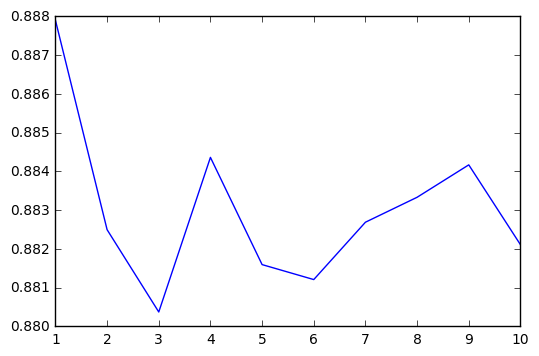

In [427]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=200, 
                                   oob_score=True, 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   max_features=0.9, 
                                   min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    print (min_samples, "min samples")
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, min_samples_leaf_options).plot();

### min_samples_leaf

None class weight
C-stat:  0.887902187902

balanced class weight
C-stat:  0.885006435006

balanced_subsample class weight
C-stat:  0.885070785071



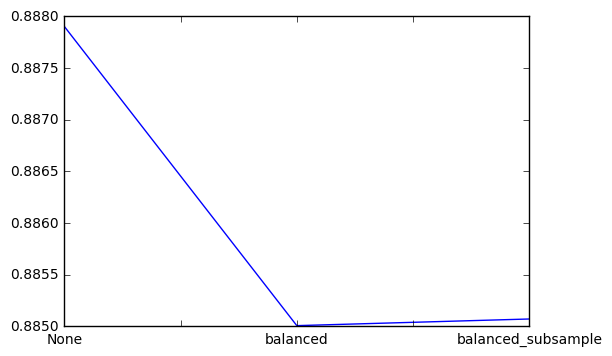

In [428]:
results = []
class_weight_options = [None, "balanced", "balanced_subsample"]

for class_weight in class_weight_options:
    model = RandomForestClassifier(n_estimators=200, 
                                   oob_score=True, 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   max_features=0.9, 
                                   min_samples_leaf=1,
                                   class_weight=class_weight)
    model.fit(X_train, y_train)
    print (class_weight, "class weight")
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, class_weight_options).plot();

## Final model

In [430]:
model = RandomForestClassifier(n_estimators=200, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features=0.9,
                              min_samples_leaf=1,
                              class_weight=None)
model.fit(X_train, y_train)
roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print ("C-stat: ", roc)

C-stat:  0.887902187902
